# Guide for the HiggsToBB dataset (Part 2)

This notebook is a guide for using the HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC dataset. 

In Part 2, we focus on machine learning tasks on this dataset.

# Dataset

Cite as: Duarte, Javier; (2019). Sample with jet, track and secondary vertex properties for Hbb tagging ML studies HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC. CERN Open Data Portal. DOI:[10.7483/OPENDATA.CMS.JGJX.MS7Q](http://doi.org/10.7483/OPENDATA.CMS.JGJX.MS7Q)

## Description: 

The dataset has been produced for developing machine-learning algorithms to differentiate jets originating from a Higgs boson decaying to a bottom quark-antiquark pair (Hbb) from quark or gluon jets originating from quantum chromodynamic (QCD) multijet production.

The reconstructed jets are clustered using the anti-kT algorithm with R=0.8 from particle flow (PF) candidates (AK8 jets). The standard L1+L2+L3+residual jet energy corrections are applied to the jets and pileup contamination is mitigated using the charged hadron subtraction (CHS) algorithm. Features of the AK8 jets with transverse momentum pT > 200 GeV and pseudorapidity |η| < 2.4 are provided. Selected features of inclusive (both charged and neutral) PF candidates with pT > 0.95 GeV associated to the AK8 jet are provided. Additional features of charged PF candidates (formed primarily by a charged particle track) with pT > 0.95 GeV associated to the AK8 jet are also provided. Finally, additional features of reconstructed secondary vertices (SVs) associated to the AK8 jet (within ∆R < 0.8) are also provided.

## File Information

There are two lists of files, one in ROOT format and another in H5. For H5 files, only information for up to 100 particle candidates, up to 60 charged particles or tracks, and up to 5 secondary vertices are stored in zero-padded arrays. 

List of H5 files: 
- Test: http://opendata.cern.ch/record/12102/files/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC_test_h5_file_index.txt
- Train: http://opendata.cern.ch/record/12102/files/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC_train_h5_file_index.txt

List of ROOT files:
- Test: http://opendata.cern.ch/record/12102/files/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC_test_root_file_index.txt
- Train: http://opendata.cern.ch/record/12102/files/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC_train_root_file_index.txt

The size of each H5 file is 1.4 GB, and the size of each ROOT file is 1.1 GB. 

This notebook help you walk through the **H5** format dataset, and it's derived from this list of notebooks that are developed for the **ROOT** format: https://jmduarte.github.io/capstone-particle-physics-domain/weeks/02-dataset.html

In [3]:
import tables
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd

filename = 'ntuple_merged_11.h5' # train file
if not os.path.isfile(filename):
    !wget http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.h5 .

# Part 2. Machine Learning Examples  
## 2.1 Classification: Particle Identification

**Features**: dimension (n,27)

**Labels**: dimension (n,2) in one-hot. (1,0) means background(QCD) and (0,1) means H(bb).

**Classifiers**:

1. Decision Tree Classifier: max depth = 5
2. SVM Classifier
3. Fully Connected Neural Network Classifier: optimizer='adam', loss='categorical_crossentropy', metrics='accuracy'

In [6]:
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [9]:
# selected features useful for the classification task.
features = ['fj_jetNTracks', # Number of tracks associated with the AK8 jet
            'fj_nSV',  # Number of SVs associated with the AK8 jet (∆R < 0.7)
            'fj_tau0_trackEtaRel_0',# Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the 1st N-subjettiness axis
            'fj_tau0_trackEtaRel_1', # Second smallest ...
            'fj_tau0_trackEtaRel_2', # Third smallest ...
            'fj_tau1_trackEtaRel_0', # Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the 2nd N-subjettiness axis
            'fj_tau1_trackEtaRel_1', # Second smallest ...
            'fj_tau1_trackEtaRel_2', # Thrid smallest ...
            'fj_tau_flightDistance2dSig_0', # Transverse (2D) flight distance significance between the PV and the SV with the smallest uncertainty on the 3D flight distance associated to the first N-subjettiness axis
            'fj_tau_flightDistance2dSig_1', # ... associated to the second N-subjettiness axis
            'fj_tau_vertexDeltaR_0',  # Pseudoangular distance ∆R between the first N-subjettiness axis and SV direction
            'fj_tau_vertexEnergyRatio_0', # SV vertex energy ratio for the first N-subjettiness axis, defined as the total energy of all SVs associated with the first N-subjettiness axis divided by the total energy of all the tracks associated with the AK8 jet that are consistent with the PV
            'fj_tau_vertexEnergyRatio_1', # SV vertex energy ratio for the second N-subjettiness axis
            'fj_tau_vertexMass_0', 
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass', # Soft drop mass of the AK8 jet
              'fj_pt'] # Transverse momentum of the AK8 jet

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

def get_features_labels(file_name, remove_mass_pt_window=True):

    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

# load training file
train_filename = 'ntuple_merged_10.h5'
if not os.path.isfile(train_filename):
     !wget http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .
feature_array, label_array = get_features_labels(train_filename, remove_mass_pt_window=False)
print(feature_array.shape, label_array.shape)

--2021-05-04 14:03:19--  http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5
Resolving opendata.cern.ch (opendata.cern.ch)... 188.185.82.144, 188.184.93.89, 188.184.28.138
Connecting to opendata.cern.ch (opendata.cern.ch)|188.185.82.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1506845769 (1.4G) [application/octet-stream]
Saving to: ‘ntuple_merged_10.h5’

ntuple_merged_10.h5   1%[                    ]  14.78M  55.8KB/s    eta 5h 28m ^C


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1652, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 623, in H5F__super_read
    truncated file: eof = 15513498, sblock->base_addr = 0, stored_eof = 1506845769

End of HDF5 error back trace

Unable to open/create file 'ntuple_merged_10.h5'

**Decision Tree Classifier**

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(feature_array, label_array[:,1])

**Support Vector Machine Classifier**

In [ ]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(feature_array, label_array[:,1])

**Fully Connected Neural Network Classifier**

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Define dense keras model:")
print(keras_model.summary())

**Train FCNN model**

In [ ]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
ep = 100 # epoch
history  = keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=ep, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

In [ ]:
plt.figure()
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.title("Loss vs Epoch during training on ntuple_merged_0.h5")
plt.show()

**Test and Compare All 3 Models**

In [8]:
test_filename = 'ntuple_merged_0.h5'
if not os.path.isfile(test_filename): 
    !wget http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .

--2021-05-04 14:02:02--  http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.28.138, 188.184.93.89, 188.185.82.144
Connecting to opendata.cern.ch (opendata.cern.ch)|188.184.28.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1506140388 (1.4G) [application/octet-stream]
Saving to: ‘ntuple_merged_0.h5’

ntuple_merged_0.h5    0%[                    ]   8.01M  46.4KB/s    eta 3h 47m ^C


In [11]:
# load training file
feature_array_test, label_array_test = get_features_labels(test_filename, remove_mass_pt_window=False)

In [12]:
print("Test on file %s" %test_filename)
# run model inference on test data set
predict_array_nn = np.argmax(keras_model.predict(feature_array_test),axis=1)
predict_array_tree = np.argmax(clf.predict_proba(feature_array_test),axis=1)
predict_array_svm = svm.decision_function(feature_array_test)
predict_array_svm = (predict_array_svm>0).astype(int)

# print test accuracy
[nn_test_loss, nn_test_accuracy] = keras_model.evaluate(feature_array_test, label_array_test)
print("Neural network:\n Test_loss: %f, Test_accuracy: %f" %(nn_test_loss, nn_test_accuracy))

acc_tree = np.sum((predict_array_tree==label_array_test[:,1]).astype(int))/len(predict_array_tree)
print("Decision Tree Classifier \n Test_accuracy: %f"%acc_tree )

acc_svm = np.sum((predict_array_svm==label_array_test[:,1]).astype(int))/len(predict_array_svm)
print("SVM \n Test_accuracy: %f"%acc_svm )

Test on file ntuple_merged_11.h5
187653/187653 [==============================] - 2s 10us/step
Neural network:
 Test_loss: 0.219699, Test_accuracy: 0.915221
Decision Tree Classifier 
 Test_accuracy: 0.902522
SVM 
 Test_accuracy: 0.889445


## 2.2 Regression: Energy Reconstruction 

In energy reconstruction example, the regression target is **fj_gen_pt**. It is the Transverse momentum of the generator-level, geometrically matched heavy particle: H, W, Z, t, etc. (default = -999)

**Input**: 
    
    features: dimension (n,27)
    
**Output**: 
    
    fj_gen_pt: (n,1)
    
**Model**: 
    
    Fully connected nueral network
    
In the following example, we use the same set of features as in the classification example to reconstruct the **fj_gen_pt** we target at.
    

In [13]:
gen_pts = ['fj_gen_pt']

def get_features_gen(file_name, remove_mass_pt_window=False):

    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))
    gen_pt_array = np.zeros((njets,1))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    for gen in gen_pts:
        gen_pt_array[:,0] = getattr(h5file.root,gen)[:]
        
    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    gen_pt_array = gen_pt_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    feature_array = feature_array[gen_pt_array[:,0]>=0]
    label_array = label_array[gen_pt_array[:,0]>=0]
    gen_pt_array = gen_pt_array[gen_pt_array[:,0]>=0]
    
    h5file.close()
    return feature_array, label_array, gen_pt_array


# load training file
train_filename = 'ntuple_merged_11.h5'
feature_array2, label_array2, gen_pt_array = get_features_gen(train_filename, remove_mass_pt_window=False)

In [14]:
# Losses and Metrics
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [48]:
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, kernel_initializer='he_uniform', activation='relu')(x)
outputs = Dense(1, name = 'output')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss=mse, metrics=[r_square, rmse])
print("Define dense keras model:")
print(keras_model.summary())

Define dense keras model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 27)                0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 27)                108       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1792      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 1,965
Trainable params: 1,911
Non-trainable params: 54
_________________________________________________________________
None


In [49]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_regression_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
ep = 300
history  = keras_model.fit(feature_array2, gen_pt_array, batch_size=1024, 
                epochs=ep, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

Train on 19824 samples, validate on 4956 samples
Epoch 1/300
19824/19824 [==============================] - 0s 25us/step - loss: 1264881.6499 - r_square: -4.8171 - rmse: 1023.2984 - val_loss: 1266823.0690 - val_r_square: -4.9133 - val_rmse: 1025.7532
Epoch 2/300
19824/19824 [==============================] - 0s 2us/step - loss: 1261852.5013 - r_square: -4.8031 - rmse: 1021.8276 - val_loss: 1263659.1794 - val_r_square: -4.8986 - val_rmse: 1024.2299
Epoch 3/300
19824/19824 [==============================] - 0s 2us/step - loss: 1258434.1799 - r_square: -4.7874 - rmse: 1020.1701 - val_loss: 1259960.2968 - val_r_square: -4.8813 - val_rmse: 1022.4518
Epoch 4/300
19824/19824 [==============================] - 0s 2us/step - loss: 1254353.6929 - r_square: -4.7686 - rmse: 1018.1949 - val_loss: 1255459.5257 - val_r_square: -4.8603 - val_rmse: 1020.2927
Epoch 5/300
19824/19824 [==============================] - 0s 2us/step - loss: 1249348.2527 - r_square: -4.7456 - rmse: 1015.7760 - val_loss: 1249

Epoch 42/300
19824/19824 [==============================] - 0s 2us/step - loss: 222442.8662 - r_square: -0.0223 - rmse: 377.0398 - val_loss: 216335.2309 - val_r_square: -0.0093 - val_rmse: 370.6843
Epoch 43/300
19824/19824 [==============================] - 0s 2us/step - loss: 221144.7966 - r_square: -0.0163 - rmse: 376.1347 - val_loss: 215069.0489 - val_r_square: -0.0034 - val_rmse: 369.8082
Epoch 44/300
19824/19824 [==============================] - 0s 2us/step - loss: 219948.6643 - r_square: -0.0108 - rmse: 375.3064 - val_loss: 213899.7148 - val_r_square: 0.0021 - val_rmse: 368.9916
Epoch 45/300
19824/19824 [==============================] - 0s 2us/step - loss: 218843.8016 - r_square: -0.0057 - rmse: 374.5359 - val_loss: 212818.7993 - val_r_square: 0.0071 - val_rmse: 368.2317
Epoch 46/300
19824/19824 [==============================] - 0s 2us/step - loss: 217820.6498 - r_square: -0.0010 - rmse: 373.8146 - val_loss: 211818.6226 - val_r_square: 0.0118 - val_rmse: 367.5407
Epoch 47/300


Epoch 84/300
19824/19824 [==============================] - 0s 2us/step - loss: 201927.2309 - r_square: 0.0721 - rmse: 362.1972 - val_loss: 196827.2966 - val_r_square: 0.0819 - val_rmse: 356.2726
Epoch 85/300
19824/19824 [==============================] - 0s 2us/step - loss: 201747.8334 - r_square: 0.0729 - rmse: 362.0539 - val_loss: 196673.8698 - val_r_square: 0.0826 - val_rmse: 356.1537
Epoch 86/300
19824/19824 [==============================] - 0s 2us/step - loss: 201573.6224 - r_square: 0.0737 - rmse: 361.9151 - val_loss: 196525.4057 - val_r_square: 0.0833 - val_rmse: 356.0376
Epoch 87/300
19824/19824 [==============================] - 0s 2us/step - loss: 201404.7546 - r_square: 0.0745 - rmse: 361.7797 - val_loss: 196382.2781 - val_r_square: 0.0840 - val_rmse: 355.9251
Epoch 88/300
19824/19824 [==============================] - 0s 2us/step - loss: 201240.9084 - r_square: 0.0752 - rmse: 361.6472 - val_loss: 196243.9157 - val_r_square: 0.0846 - val_rmse: 355.8152
Epoch 89/300
19824/1

Epoch 126/300
19824/19824 [==============================] - 0s 2us/step - loss: 197197.8139 - r_square: 0.0938 - rmse: 358.1823 - val_loss: 193020.8839 - val_r_square: 0.0997 - val_rmse: 353.2216
Epoch 127/300
19824/19824 [==============================] - 0s 2us/step - loss: 197120.7441 - r_square: 0.0942 - rmse: 358.1087 - val_loss: 192959.5518 - val_r_square: 0.1000 - val_rmse: 353.1729
Epoch 128/300
19824/19824 [==============================] - 0s 2us/step - loss: 197044.1422 - r_square: 0.0945 - rmse: 358.0353 - val_loss: 192898.1562 - val_r_square: 0.1003 - val_rmse: 353.1234
Epoch 129/300
19824/19824 [==============================] - 0s 2us/step - loss: 196967.7869 - r_square: 0.0949 - rmse: 357.9614 - val_loss: 192836.8223 - val_r_square: 0.1006 - val_rmse: 353.0752
Epoch 130/300
19824/19824 [==============================] - 0s 2us/step - loss: 196891.8841 - r_square: 0.0952 - rmse: 357.8890 - val_loss: 192775.5547 - val_r_square: 0.1008 - val_rmse: 353.0273
Epoch 131/300
1

Epoch 209/300
19824/19824 [==============================] - 0s 2us/step - loss: 190072.7418 - r_square: 0.1266 - rmse: 350.8265 - val_loss: 185926.4245 - val_r_square: 0.1328 - val_rmse: 346.8260
Epoch 210/300
19824/19824 [==============================] - 0s 3us/step - loss: 189974.2783 - r_square: 0.1270 - rmse: 350.7204 - val_loss: 185811.2544 - val_r_square: 0.1334 - val_rmse: 346.7181
Epoch 211/300
19824/19824 [==============================] - 0s 2us/step - loss: 189876.3116 - r_square: 0.1275 - rmse: 350.6148 - val_loss: 185696.1027 - val_r_square: 0.1339 - val_rmse: 346.6103
Epoch 212/300
19824/19824 [==============================] - 0s 2us/step - loss: 189778.7309 - r_square: 0.1279 - rmse: 350.5102 - val_loss: 185582.0919 - val_r_square: 0.1344 - val_rmse: 346.5049
Epoch 213/300
19824/19824 [==============================] - 0s 2us/step - loss: 189681.5231 - r_square: 0.1284 - rmse: 350.4068 - val_loss: 185467.4597 - val_r_square: 0.1350 - val_rmse: 346.4004
Epoch 214/300
1

Epoch 292/300
19824/19824 [==============================] - 0s 2us/step - loss: 184555.8277 - r_square: 0.1520 - rmse: 344.4433 - val_loss: 179760.8578 - val_r_square: 0.1616 - val_rmse: 340.2712
Epoch 293/300
19824/19824 [==============================] - 0s 2us/step - loss: 184515.9922 - r_square: 0.1521 - rmse: 344.3956 - val_loss: 179724.3786 - val_r_square: 0.1618 - val_rmse: 340.2202
Epoch 294/300
19824/19824 [==============================] - 0s 2us/step - loss: 184476.1262 - r_square: 0.1523 - rmse: 344.3480 - val_loss: 179686.4839 - val_r_square: 0.1620 - val_rmse: 340.1712
Epoch 295/300
19824/19824 [==============================] - 0s 2us/step - loss: 184436.5783 - r_square: 0.1525 - rmse: 344.3028 - val_loss: 179649.2909 - val_r_square: 0.1621 - val_rmse: 340.1203
Epoch 296/300
19824/19824 [==============================] - 0s 2us/step - loss: 184397.0899 - r_square: 0.1527 - rmse: 344.2563 - val_loss: 179611.8187 - val_r_square: 0.1623 - val_rmse: 340.0709
Epoch 297/300
1

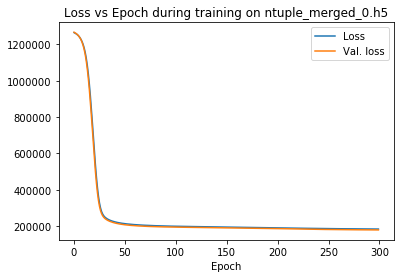

In [50]:
plt.figure()
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.title("Loss vs Epoch during training on ntuple_merged_0.h5")
plt.show()

In [51]:
# Test and Evaluate 
# load training file
test_filename = 'ntuple_merged_0.h5'
feature_array_test2, label_array_test2, gen_pt_array_test = get_features_gen(test_filename, remove_mass_pt_window=False)
predict_array_nn = keras_model.predict(feature_array_test2)

In [52]:
[nn_test_mse, nn_test_rsquare, nn_test_rmse] = keras_model.evaluate(feature_array_test2, gen_pt_array_test)
print("Neural network:\n Test_loss: %f, Test_r_square: %f, Test_rmse: %f" %(nn_test_mse, nn_test_rsquare, nn_test_rmse))

24780/24780 [==============================] - 0s 11us/step
Neural network:
 Test_loss: 183829.230307, Test_r_square: 0.119075, Test_rmse: 343.150444
